In [1]:
import pandas as pd
import matplotlib as pyplot
import numpy as np
import seaborn as sns
import sklearn
import math
import matplotlib.pyplot as plt

from collections import OrderedDict
from hmmlearn import hmm

In [2]:
devices_dataset = pd.read_csv("house_devices.csv")

In [3]:
devices_dataset.head()

,time,lighting2,lighting5,lighting4,refrigerator,microwave
0,1302930703,180,23,195,117,2
1,1302930721,181,23,195,119,2
2,1302930738,180,23,195,117,2
3,1302930765,181,23,195,117,2
4,1302930782,180,23,195,118,2


In [4]:
devices_dataset.shape

(14999, 6)

In [5]:
devices_dataset.describe()

,time,lighting2,lighting5,lighting4,refrigerator,microwave
count,1.499900e+04,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,1.303161e+09,46.444630,17.852990,45.995933,46.283086,6.710247
std,1.315710e+05,91.600463,45.832236,70.079602,66.730693,88.110723
min,1.302931e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.303068e+09,0.000000,1.000000,0.000000,0.000000,2.000000
50%,1.303144e+09,0.000000,1.000000,0.000000,1.000000,2.000000
75%,1.303299e+09,22.000000,21.000000,63.000000,115.000000,2.000000
max,1.303371e+09,362.000000,211.000000,203.000000,916.000000,1798.000000


In [6]:
devices_dataset.nunique()

time            14999
lighting2          58
lighting5          61
lighting4          96
refrigerator      109
microwave          50
dtype: int64

## Learning process

In [8]:
devices_names = devices_dataset.columns[1:]
hidden_states = [i for i in range(4, 8) if i % 2 == 0]


class ModelsContainer:
    __slots__ = ['models', 'scores', 'states']

    def __init__(self):
        self.models = []
        self.scores = []
        self.states = []

    def add_model(self, model, score, state):
        self.models.append(model)
        self.scores.append(score)
        self.states.append(state)

    def get_best_model(self):
        max_score_idx = self.scores.index(max(self.scores))
        return self.models[max_score_idx], self.scores[max_score_idx], self.states[max_score_idx]


def train_test(dataset):
    train_size = int(dataset.shape[0] * 0.8)
    train_sample = np.random.choice(dataset.index, size=train_size)
    train_set = dataset.loc[train_sample, :]
    test_set_sample = dataset.index.difference(train_set.index)
    test_set = dataset.loc[test_set_sample, :]

    train_set = train_set.sort_values(by="time")
    test_set = test_set.sort_values(by="time")
    return train_set, test_set


def extract_column(X_train, X_test, col_name):
    return X_train[[col_name]], X_test[[col_name]]


def select_hidden_state(X_train, X_test, hidden_states):
    models_container = ModelsContainer()
    for hs in hidden_states:
        hmm_model = hmm.GaussianHMM(n_components=hs, n_iter=10)
        hmm_model.fit(X_train)
        model_score = hmm_model.score(X_test)
        models_container.add_model(hmm_model, model_score, hs)
    return models_container.get_best_model()


def select_best_model(dataset, col_name, hidden_states, reps=3):
    models_container = ModelsContainer()
    for _ in range(reps):
        X_train, X_test = train_test(dataset)
        X_train, X_test = extract_column(X_train, X_test, col_name)
        model, score, hs = select_hidden_state(X_train, X_test, hidden_states)
        models_container.add_model(model, score, hs)
    return models_container.get_best_model()

In [9]:
collected_models = OrderedDict()
for devices_cols in devices_dataset.columns[1:]:
    collected_models[devices_cols] = select_best_model(devices_dataset, devices_cols, hidden_states)

In [10]:
dev_len = len(devices_names)
results_mtrx = np.zeros((dev_len, dev_len))
X_train, X_test = train_test(devices_dataset)
for i, (model_name, model_info) in enumerate(collected_models.items()):
    model = model_info[0]
    for j, dn in enumerate(devices_names):
        _, X_test_col = extract_column(X_train, X_test, dn)
        model_prediction = model.score(X_test_col[[dn]])
        results_mtrx[j, i] = model_prediction

In [11]:
result_df = pd.DataFrame(results_mtrx)
result_df.columns = devices_names

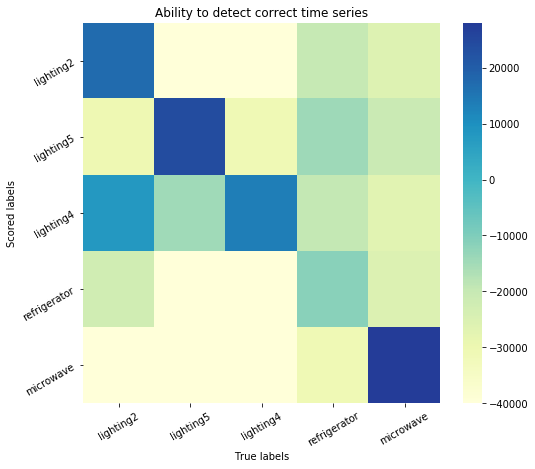

In [13]:
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(result_df.clip(lower=-40000),
            center=0,
            cmap="YlGnBu",
            yticklabels=devices_names,
            ax=ax)
ax.set_title('Ability to detect correct time series')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
ax.set_xlabel('True labels')
ax.set_ylabel('Scored labels');